## 0. Libarary 불러오기 및 경로설정

In [90]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, RandomHorizontalFlip, CenterCrop
from tqdm import tqdm


In [91]:
!pwd

/opt/ml/code


In [92]:
!cd /opt/ml/input/data/train/images
!ls

EDA.ipynb  mask.ipynb  models  requirements.txt  sample_submission.ipynb


In [93]:
img_dir = '/opt/ml/input/data/train/images'
info_dir = '/opt/ml/input/data/train/train.csv'

In [94]:
info = pd.read_csv(info_dir)

In [95]:
info

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [96]:
person_dir = info['path']
person_dir


0       000001_female_Asian_45
1       000002_female_Asian_52
2         000004_male_Asian_54
3       000005_female_Asian_58
4       000006_female_Asian_59
                 ...          
2695      006954_male_Asian_19
2696      006955_male_Asian_19
2697      006956_male_Asian_19
2698      006957_male_Asian_20
2699      006959_male_Asian_19
Name: path, Length: 2700, dtype: object

In [97]:
# split test to get gender and age
pdir = person_dir[0]
split_str = pdir.split('_')
gender = split_str[1]
age = split_str[3]

print(gender, age)

female 45


In [98]:
# numerize classes function

def get_class(dict):
    if dict['mask'] == 0:#wear
        if dict['gen'] == 'male':
            if dict['age'] < 30:
                return 0
            elif 30 <= dict['age'] < 60:
                return 1
            else:
                return 2
        else:
            if dict['age'] < 30:
                return 3
            elif 30 <= dict['age'] < 60:
                return 4
            else:
                return 5
    elif dict['mask'] == 1:#incorrect
        if dict['gen'] == 'male':
            if dict['age'] < 30:
                return 6
            elif 30 <= dict['age'] < 60:
                return 7
            else:
                return 8
        else:
            if dict['age'] < 30:
                return 9
            elif 30 <= dict['age'] < 60:
                return 10
            else:
                return 11
    elif dict['mask'] == 2:#normal
        if dict['gen'] == 'male':
            if dict['age'] < 30:
                return 12
            elif 30 <= dict['age'] < 60:
                return 13
            else:
                return 14
        else:
            if dict['age'] < 30:
                return 15
            elif 30 <= dict['age'] < 60:
                return 16
            else:
                return 17

get_class({'mask':0, 'gen':'male', 'age':64})

2

In [99]:
# create image_paths\
# current status: eacp person, each mask or not.
# need to sepereate them to a state that (one eg, one label).

# may the label process be here? or in dataset? here: two functions in one cell. dataset: time taking and messy index to split.
img_paths = []
status = ['incorrect_mask', 'normal']

labels = []

for i in range(5):
    status.append('mask' + str(i+1))
print(status)

for p_dir in person_dir:
    
    split_str = p_dir.split('_')
    gender = split_str[1]
    age = split_str[3]
    
    for idx, st in enumerate(status):
        img_paths.append(img_dir + "/" + p_dir + "/" + st)

        label_stat = {}
        if idx == 0:
            label_stat['mask'] = 1
        elif idx == 1:
            label_stat['mask'] = 2
        else:
            label_stat['mask'] = 0
        
        label_stat['age'] = int(age)
        label_stat['gen'] = gender
        
        labels.append(get_class(label_stat))
        
        
        
print(len(img_paths))
for i in range(10*3):
    print(img_paths[i], " -> ", labels[i])
    

['incorrect_mask', 'normal', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5']
18900
/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask  ->  10
/opt/ml/input/data/train/images/000001_female_Asian_45/normal  ->  16
/opt/ml/input/data/train/images/000001_female_Asian_45/mask1  ->  4
/opt/ml/input/data/train/images/000001_female_Asian_45/mask2  ->  4
/opt/ml/input/data/train/images/000001_female_Asian_45/mask3  ->  4
/opt/ml/input/data/train/images/000001_female_Asian_45/mask4  ->  4
/opt/ml/input/data/train/images/000001_female_Asian_45/mask5  ->  4
/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask  ->  10
/opt/ml/input/data/train/images/000002_female_Asian_52/normal  ->  16
/opt/ml/input/data/train/images/000002_female_Asian_52/mask1  ->  4
/opt/ml/input/data/train/images/000002_female_Asian_52/mask2  ->  4
/opt/ml/input/data/train/images/000002_female_Asian_52/mask3  ->  4
/opt/ml/input/data/train/images/000002_female_Asian_52/mask4  ->  4
/opt/ml/inpu

# create only normal and incorrect dataset

In [100]:
img_paths_false = []
status = ['incorrect_mask', 'normal']

labels_false = []

# for i in range(5):
#     status.append('mask' + str(i+1))
# print(status)

for p_dir in person_dir:
    
    split_str = p_dir.split('_')
    gender = split_str[1]
    age = split_str[3]
    
    for idx, st in enumerate(status):
        img_paths_false.append(img_dir + "/" + p_dir + "/" + st)

        label_stat = {}
        if idx == 0:
            label_stat['mask'] = 1
        elif idx == 1:
            label_stat['mask'] = 2
        else:
            label_stat['mask'] = 0
        
        label_stat['age'] = int(age)
        label_stat['gen'] = gender
        
        labels_false.append(get_class(label_stat))
        
        
        
print(len(img_paths_false))
for i in range(5):
    print(img_paths_false[i], " -> ", labels_false[i])

5400
/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask  ->  10
/opt/ml/input/data/train/images/000001_female_Asian_45/normal  ->  16
/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask  ->  10
/opt/ml/input/data/train/images/000002_female_Asian_52/normal  ->  16
/opt/ml/input/data/train/images/000004_male_Asian_54/incorrect_mask  ->  7


# Only positive data

In [101]:
img_paths_true = []
status = []

labels_true = []

for i in range(5):
    status.append('mask' + str(i+1))
print(status)

for p_dir in person_dir:
    
    split_str = p_dir.split('_')
    gender = split_str[1]
    age = split_str[3]
    
    for idx, st in enumerate(status):
        img_paths_true.append(img_dir + "/" + p_dir + "/" + st)

        label_stat = {}
        if idx == 0:
            label_stat['mask'] = 1
        elif idx == 1:
            label_stat['mask'] = 2
        else:
            label_stat['mask'] = 0
        
        label_stat['age'] = int(age)
        label_stat['gen'] = gender
        
        labels_true.append(get_class(label_stat))
        
        
        
print(len(img_paths_true))
for i in range(5):
    print(img_paths_true[i], " -> ", labels_true[i])

['mask1', 'mask2', 'mask3', 'mask4', 'mask5']
13500
/opt/ml/input/data/train/images/000001_female_Asian_45/mask1  ->  10
/opt/ml/input/data/train/images/000001_female_Asian_45/mask2  ->  16
/opt/ml/input/data/train/images/000001_female_Asian_45/mask3  ->  4
/opt/ml/input/data/train/images/000001_female_Asian_45/mask4  ->  4
/opt/ml/input/data/train/images/000001_female_Asian_45/mask5  ->  4


In [102]:
class MaskDataset(Dataset):
    def __init__(self, img_paths, labels, transform = None):
        self.img_paths = img_paths
        self.transform = transform
        self.labels = labels

    def __getitem__(self, index):
        pth = self.img_paths[index]
        
        if os.path.exists(pth + '.jpg'):
            self.img_paths[index] = pth + '.jpg'
        elif os.path.exists(pth + '.png'):
            self.img_paths[index] = pth + '.png'
        elif os.path.exists(pth + '.jpeg'):
            self.img_paths[index] = pth + '.jpeg'
            
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        else:
#             image = transforms.Resize((64,64))(image)
            image = transforms.ToTensor()(image)
        return image, self.labels[index]

    def show_pic(self, index):
        image = Image.open(self.img_paths[index])
#         image = transforms.Resize((64,64))(image)
        return image

    def __len__(self):
        return len(self.img_paths)
    
    def __repr__(self):
        return "number of dataset : " + str(self.__len__())

In [103]:
def get_transforms_img(im):
    ######################################TODO######################################
    im = transforms.ToTensor()(im)
    im = transforms.Resize((224,224))(im)
    im = transforms.RandomHorizontalFlip(0.5)(im)
    im = transforms.CenterCrop((150,150))(im)

    ################################################################################
    return im

# Test speed of data generator

In [104]:
# # test speed of data generator without transforms
# t = MaskDataset(img_paths, labels)
# for idx, d in enumerate(tqdm(t)):
#     pass

In [105]:
# # test speed of data generator with transforms. totensor, resize, randomhorizontalflip, centercrop
# t = MaskDataset(img_paths, labels, get_transforms_img)
# for idx, d in enumerate(tqdm(t)):
#     pass

In [106]:
# # test speed of data generator with transforms. totensor, resize, randomhorizontalflip, centercrop
# t = MaskDataset(img_paths, labels)
# for idx, d in enumerate(tqdm(t)):
#     pass

# composed = transforms.Compose([
#     ToTensor(),
#     Resize((224,224)),
#     RandomHorizontalFlip(0.5),
#     CenterCrop((150,150))
# ])

# # test speed of data generator with transforms. totensor, resize, randomhorizontalflip, centercrop
# t = MaskDataset(img_paths, labels, composed)
# for idx, d in enumerate(tqdm(t)):
#     pass

# composed = transforms.Compose([

#     Resize((224,224)),
#     RandomHorizontalFlip(0.5),
#     CenterCrop((150,150)),
#     ToTensor()
# ])

# # test speed of data generator with transforms. totensor, resize, randomhorizontalflip, centercrop
# t = MaskDataset(img_paths, labels, composed)
# for idx, d in enumerate(tqdm(t)):
#     pass


# Concatinate dataset with correct, incorrect, normal.
lets deal with the imbalance!

In [107]:
dataset = MaskDataset(img_paths, labels, get_transforms_img)
# dataset = MaskDataset(img_paths, labels) # 0.87 0.81 f1
dataset

number of dataset : 18900

In [108]:
# true and false dataset

# false_dataset = MaskDataset(img_paths_false, labels_false, get_transforms_img)
# true_dataset = MaskDataset(img_paths_true, labels_true, get_transforms_img)

false_dataset = MaskDataset(img_paths_false, labels_false)
true_dataset = MaskDataset(img_paths_true, labels_true)


false_len = false_dataset.__len__()
true_len = true_dataset.__len__()
# int(false_len  * (1/3))


false_dataset, false_testset = torch.utils.data.random_split(false_dataset, [ int(false_len) - 100, 100 ], generator=torch.Generator().manual_seed(42))
true_dataset, true_testset = torch.utils.data.random_split(true_dataset, [ int(true_len) - 100, 100 ], generator = torch.Generator().manual_seed(42))

print(false_dataset.__len__())
print(false_testset.__len__())
print(true_dataset.__len__())
print(true_testset.__len__())

concat_dataset = torch.utils.data.ConcatDataset([false_dataset, true_dataset])
concat_testset = torch.utils.data.ConcatDataset([false_testset, true_testset])

print(len(concat_dataset))
print(len(concat_testset))

concat_dataloader = torch.utils.data.DataLoader(concat_dataset, batch_size = 64, shuffle = True, num_workers = 2)
concat_testloader = torch.utils.data.DataLoader(concat_testset, batch_size = 64, shuffle = True, num_workers = 2)


# print("false data set len = ", false_dataset.__len__())
# print("true data set len = ", true_dataset.__len__())


5300
100
13400
100
18700
200


In [109]:
dataset, testset = torch.utils.data.random_split(dataset, [18000,900], generator=torch.Generator().manual_seed(42))

In [110]:
len(dataset)

18000

In [111]:
# dataset.show_pic(1)

# issue: there are png, jpeg, pjg multiple extensions.

In [112]:
#png file test
info[info['id'] == '006148']

,id,gender,race,age,path
2311,006148,male,Asian,19,006148_male_Asian_19


In [113]:
info[info['id'] == '006582']

,id,gender,race,age,path
2560,006582,female,Asian,20,006582_female_Asian_20


In [114]:
dataset.__getitem__(2560*7)[0].shape

torch.Size([3, 150, 150])

In [115]:
dataset.__getitem__(1)[0].shape

torch.Size([3, 150, 150])

In [116]:
dataset.__getitem__(-1)

(tensor([[[0.8438, 0.8440, 0.8440,  ..., 0.8353, 0.8353, 0.8353],
          [0.8478, 0.8490, 0.8490,  ..., 0.8373, 0.8373, 0.8373],
          [0.8462, 0.8471, 0.8471,  ..., 0.8392, 0.8392, 0.8392],
          ...,
          [0.1166, 0.1137, 0.1098,  ..., 0.1473, 0.1482, 0.1467],
          [0.1261, 0.1157, 0.1083,  ..., 0.1423, 0.1431, 0.1408],
          [0.1120, 0.1052, 0.1082,  ..., 0.1449, 0.1385, 0.1363]],
 
         [[0.8124, 0.8126, 0.8126,  ..., 0.8039, 0.8039, 0.8039],
          [0.8164, 0.8176, 0.8176,  ..., 0.8059, 0.8059, 0.8059],
          [0.8148, 0.8157, 0.8157,  ..., 0.8078, 0.8078, 0.8078],
          ...,
          [0.1166, 0.1137, 0.1098,  ..., 0.1473, 0.1482, 0.1467],
          [0.1261, 0.1157, 0.1083,  ..., 0.1423, 0.1431, 0.1408],
          [0.1120, 0.1052, 0.1082,  ..., 0.1449, 0.1385, 0.1363]],
 
         [[0.7693, 0.7695, 0.7695,  ..., 0.7608, 0.7608, 0.7608],
          [0.7732, 0.7745, 0.7745,  ..., 0.7627, 0.7627, 0.7627],
          [0.7717, 0.7725, 0.7725,  ...,

In [117]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True, num_workers = 2)

In [118]:
iter(dataloader).next()[0].shape

torch.Size([64, 3, 150, 150])

# Model

In [119]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [133]:
# resnet test
import torchvision
mask_resnet_18 = torchvision.models.resnet18(pretrained = True)
# mask_resnet_18.fc = torch.nn.Linear(512, 18, bias = True)
# torch.nn.init.xavier_uniform_(mask_resnet_18.fc.weight)
# mask_resnet_18.fc.bias.data.fill_(0.01)
mask_resnet_18


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [121]:
class MaskResnot(nn.Module):
    def __init__(self, num_classes: int = 18):
        super(MaskResnot, self).__init__()
        self.resnet_18 = mask_resnet_18
        
        
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(64, 32),
#             nn.ReLU(inplace=True),
#             nn.Linear(32, num_classes),
#         )
    def init_params(self):
        torch.nn.init.xavier_uniform_(self.resnet_18.fc.weight)
        self.resnet_18.fc.bias.data.fill_(0.01)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.resnet_18(x)
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
        return x

In [122]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [123]:
model = MaskResnot(18).to(device)

In [124]:
import torch.optim as optim


In [125]:
loss = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = 1e-3)


In [126]:
model.train()
epochs = 5
model.init_params()
loss_record = []

for p in model.parameters():
    p.requires_grad = False
for p in model.resnet_18.fc.parameters():
# for p in model.fc.parameters():
    p.requires_grad = True



for e in range(epochs):
    print("epoch number :", e)
    running_loss = 0
    running_acc = 0
    n_size = 0
    for idx, (batch_in, batch_out) in enumerate(tqdm(concat_dataloader)):
        X = batch_in.to(device)
        Y = batch_out.to(device)
        
        n_size += X.size(0)
        logits = model(X)
        loss_out = loss(logits, Y)
        _, preds = torch.max(logits, 1)
        
        opt.zero_grad()
        loss_out.backward()
        opt.step()
        running_loss += loss_out.item() #* batch_in.size(0)
        
        running_acc += torch.sum(preds == Y.data).item()
        
    loss_val_avg = running_loss / len(concat_dataset)
    loss_record.append(loss_val_avg)
    print(len(concat_dataset))
    print(n_size)
    print("loss : ", loss_val_avg)
    print("acc: ", running_acc/ n_size)
# torch.save(model, './models/'+str(epochs)+ "_concat_"+'resnet_18.pt')
print("epoch = %d done!" %(epochs))

  0%|          | 0/293 [00:00<?, ?it/s]

epoch number : 0


  0%|          | 0/293 [00:00<?, ?it/s]

18700
18700
loss :  0.032970285300902506
acc:  0.34411764705882353
epoch number : 1


  0%|          | 0/293 [00:00<?, ?it/s]

18700
18700
loss :  0.02337036753720778
acc:  0.5368449197860963
epoch number : 2


  0%|          | 0/293 [00:00<?, ?it/s]

18700
18700
loss :  0.020194163975868634
acc:  0.5977005347593582
epoch number : 3


  0%|          | 0/293 [00:00<?, ?it/s]

18700
18700
loss :  0.018384154671653708
acc:  0.6285026737967915
epoch number : 4


100%|██████████| 293/293 [00:56<00:00,  5.15it/s]

18700
18700
loss :  0.016966310239093188
acc:  0.661283422459893
epoch = 5 done!


In [127]:
from sklearn.metrics import f1_score

In [128]:
import matplotlib.pyplot as plt

In [129]:
loss_record

[0.032970285300902506,
 0.02337036753720778,
 0.020194163975868634,
 0.018384154671653708,
 0.016966310239093188]

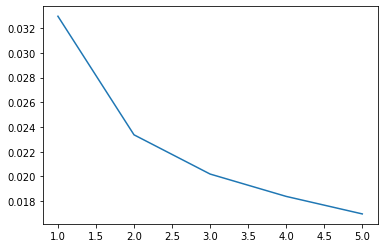

In [130]:
fig, ax = plt.subplots(1,1)
ax.plot([e+1 for e in range(epochs)], loss_record)


In [131]:
test = 5

In [132]:
model.eval()
num_acc = 0

y_true = []
y_pred = []
# print(len(false_testset))
# print(len(concat_testloader))
# for idx, (batch_in, batch_out) in enumerate(tqdm(concat_testloader)):
for idx, (batch_in, batch_out) in enumerate(tqdm(DataLoader(concat_testset))):
    with torch.no_grad():
        X = batch_in.to(device)
        Y = batch_out.to(device)
        
        logit = model(X)
        _, preds = torch.max(logit, 1)
        
        num_acc += torch.sum(preds == Y.data)
        
        y_pred += preds.cpu().detach().numpy().tolist()
        y_true += Y.cpu().detach().numpy().tolist()
        
print("accuracy = ", num_acc.item() / len(concat_testset))
score = f1_score(y_true, y_pred, average = 'micro')
print("mirco average: ", score)
score = f1_score(y_true, y_pred, average = 'macro')
print("marco average: ", score)
# print(y_pred)
# print(y_true)

100%|██████████| 200/200 [00:01<00:00, 104.20it/s]

accuracy =  0.63
mirco average:  0.63
marco average:  0.4772511950285387


# leader board
without data augmentation(only use ToTensor())
* epoch = 1; acc: 68
* epoch = 3; acc: 87
* epoch = 3; micro f1: 0.87, macro f1:0.81 

so far without data agumentation.

with data augmentaion,
* epoch = 3, micro f1: 86, macro f1:74
* epoch = 5. micro f1:91, macro f1:77
* epooch = 10. micro 95, micro 93
* epoch = 20, micro 96, macro 94
* epoch = 40, micro 98, macro 96


concat dataset
* epoch = 3, micro 83, macro 82
* epoch = 5, micro 90, macro 91
* epoch = 20, micro 95, macro 93
* epoch = 30, micro 95, macro 95

In [45]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

## 1. Model 정의

In [46]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 2. Test Dataset 정의

In [78]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

## 3. Inference

In [79]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
# model = MyModel(num_classes=18).to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
